### Import

In [2]:
import sys
import timm
from timm import create_model
from fastai.vision.all import *
import gc
import glob
import torch

In [3]:
set_seed(999, reproducible=True)
BATCH_SIZE = 32
torch.cuda.set_device(0)

In [4]:
dataset_path = Path('./')
train_df = pd.read_csv(dataset_path/'train.csv')
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [5]:
train_df['path'] = train_df['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path
0,0,0,1,1,0,0,0,0,0,0,0,1,50,train/ebaaa8e384b3d2f0a56c7ff7675c154c.jpg
1,0,1,1,1,0,1,0,1,0,0,1,0,25,train/25e3bf4267c2dc3f579b779418221bb7.jpg
2,0,0,1,1,0,1,0,0,0,0,0,0,27,train/6548166fb3fda22b67881176397f0223.jpg
3,0,1,1,1,0,0,0,0,1,1,0,0,19,train/472c40116e1833555715e4774445ae5b.jpg
4,0,1,1,1,0,0,0,1,0,0,0,0,27,train/7b77e1a6d93667b575d57db83facd860.jpg


In [6]:
train_df['norm_score'] = train_df['Pawpularity']/100

im = Image.open(train_df['path'][1])
width, height = im.size
print(width,height)

960 960


## Data loading

In [7]:
seed=999
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [8]:
#according to -new
num_bins = int(np.floor(1+(3.3)*(np.log2(len(train_df)))))
num_bins

44

Sturges rule에 따라 전체 데이터셋의 길이를 나눠서 Pawpularity에 따라 bins 순으로 나눠준다.

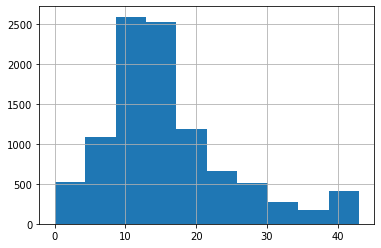

In [9]:
train_df['bins'] = pd.cut(train_df['norm_score'],bins=num_bins,labels=False)
train_df['bins'].hist();

<AxesSubplot:>

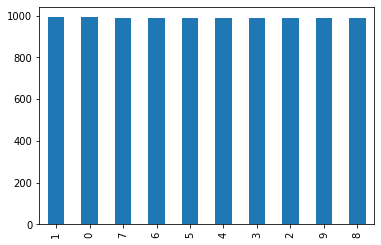

In [10]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold #bins의 밸런스를 고려하여 10폴드를 구성

train_df['fold'] = -1

N_FOLDS = 10
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state = seed, shuffle=True)

for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index,-1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

train_df.fold.value_counts().plot.bar()


In [11]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

## Inference

In [12]:
model_dir = './fast_ai_weights/384_without'
model_list = glob.glob(model_dir+'/model*')

In [13]:
test_df = pd.read_csv(dataset_path/'test.csv')
test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
test_df = test_df.drop(columns=['Id'])
train_df['norm_score'] = train_df['Pawpularity']/100

dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
                           valid_pct=0.2, #80-20 train-validation random split
                           seed=999, #seed
                           fn_col='path', #filename/path is in the second column of the DataFrame
                           label_col='norm_score', #label is in the first column of the DataFrame
                           y_block=RegressionBlock, #The type of target
                           bs=BATCH_SIZE, #pass in batch size
                           num_workers=8,
                           item_tfms=Resize(384), #pass in item_tfms
                           batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) 

test_dl = dls.test_dl(test_df)

all_preds = []
for idx,model in enumerate(model_list):
    print(f'{idx}th Fold prediction is started!')
    learner = load_learner(model,cpu=False) #swin_transformer_large_224
    tester = learner.dls.test_dl(test_df['path'])
    preds,_ = learner.tta(dl=tester, n=5,beta=0)
#     preds,_ = learner.get_preds(dl=tester)
    all_preds.append(preds)
                                

0th Fold prediction is started!


1th Fold prediction is started!


2th Fold prediction is started!


3th Fold prediction is started!


4th Fold prediction is started!


5th Fold prediction is started!


6th Fold prediction is started!


7th Fold prediction is started!


8th Fold prediction is started!


9th Fold prediction is started!


## Inference - Train

In [ ]:
learn_inference = load_learner(model_list[0])

train1 = learn_inference.dls.test_dl(train_df2['path'])

preds,y = learn_inference.get_preds(dl=train1)

In [ ]:
from sklearn.metrics import mean_squared_error

def custom_rmse(x,y):
    y_pred = x * 100
    target = y 
    
    return mean_squared_error(y_pred,target, squared=False)

In [ ]:
custom_rmse(preds,train_df2.Pawpularity)

### Inference -Test

In [ ]:
learn_inference = load_learner(model_list[0])

test = learn_inference.dls.test_dl(test_df['path'])

preds_test,y_test = learn_inference.get_preds(dl=test)

In [ ]:
all_preds=[]

for i in model_list:

    learn_inference = load_learner(i)

    test1 = learn_inference.dls.test_dl(test_df['path'])

    # preds,y =learn_inference.tta(dl=test1, n=5,beta=0)

    preds,y =learn_inference.get_preds(dl=test1)

    all_preds.append(preds)
    
    del learn_inference

    torch.cuda.empty_cache()

    gc.collect()

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
a = [0.02, 0.48, 0.79]
b = [0.01, 0.57, 0.83]

In [ ]:
mean_squared_error(a,b)

In [ ]:
mean_squared_error(a*100,b*100)